<a href="https://colab.research.google.com/github/Yang-star-source/Deep-Image-Prior/blob/master/Deep_Image_Prior_Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn

class ResNetBlock(nn.Module):
    def __init__(self,in_channels,out_channels,dropout_prob = 0.0 ):
        super().__init__()
        self.norm1 = nn.GroupNorm(32,in_channels)
        self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1,padding_mode='reflect')
        self.norm2 = nn.GroupNorm(32,out_channels)
        self.drop = nn.Dropout(dropout_prob)
        self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1,padding_mode='reflect')
        self.act = nn.LeakyReLU(0.2, inplace=True)

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels,out_channels,kernel_size=1)
        else:
            self.shortcut = nn.Identity()

    def forward(self,x):
        x1 = x

        x = self.norm1(x)
        x = self.act(x)
        x = self.conv1(x)

        x = self.norm2(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.conv2(x)
        return x + self.shortcut(x1)

class DownBlock(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.res1 = ResNetBlock(in_channels,out_channels)
        self.res2 = ResNetBlock(out_channels,out_channels)
        self.down = nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=2,padding=1,padding_mode='reflect')

    def forward(self,x):
        x = self.res1(x)
        x = self.res2(x)

        skip_connection = x

        x = self.down(x)
        return x , skip_connection

class MidBlock(nn.Module):
    def __init__(self,in_channels):
        super().__init__()

        self.res1 = ResNetBlock(in_channels,in_channels)
        self.res2 = ResNetBlock(in_channels,in_channels)

    def forward(self,x):
        x = self.res1(x)
        x = self.res2(x)
        return x

class UpBlock(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()

        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels,in_channels,kernel_size=3,padding=1,padding_mode='reflect')
        )
        # Why input *2 ? Because we have to concatenate the channels
        self.res1 = ResNetBlock(in_channels*2,out_channels)
        self.res2 = ResNetBlock(out_channels,out_channels)

    def forward(self,x,skip_connection):
        x = self.up(x)

        # cancatenate at channels dimension
        x = torch.cat([x,skip_connection],dim=1)
        x = self.res1(x)
        x = self.res2(x)
        return x

class Unet(nn.Module):
    def __init__(self,in_channels=3,out_channels=3):
        super().__init__()

        self.init_conv = nn.Conv2d(in_channels,64,kernel_size=3,padding=1,padding_mode='reflect')

        self.down1 = DownBlock(64,64)
        self.down2 = DownBlock(64,128)
        self.down3 = DownBlock(128,128)
        self.down4 = DownBlock(128,256)

        self.mid = MidBlock(256)

        self.up1 = UpBlock(256,128)
        self.up2 = UpBlock(128,128)
        self.up3 = UpBlock(128,64)
        self.up4 = UpBlock(64,64)

        self.out = nn.Sequential(
            nn.GroupNorm(32,64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64,out_channels,kernel_size=3,padding=1,padding_mode='reflect')
        )

    def forward(self,x):

        x = self.init_conv(x)

        x1 , skip1 = self.down1(x)
        x2 , skip2 = self.down2(x1)
        x3 , skip3 = self.down3(x2)
        x4 , skip4 = self.down4(x3)

        x = self.mid(x4)

        x = self.up1(x,skip4)
        x = self.up2(x,skip3)
        x = self.up3(x,skip2)
        x = self.up4(x,skip1)

        x = self.out(x)
        return x




Epoch 900 Loss 0.2762463092803955


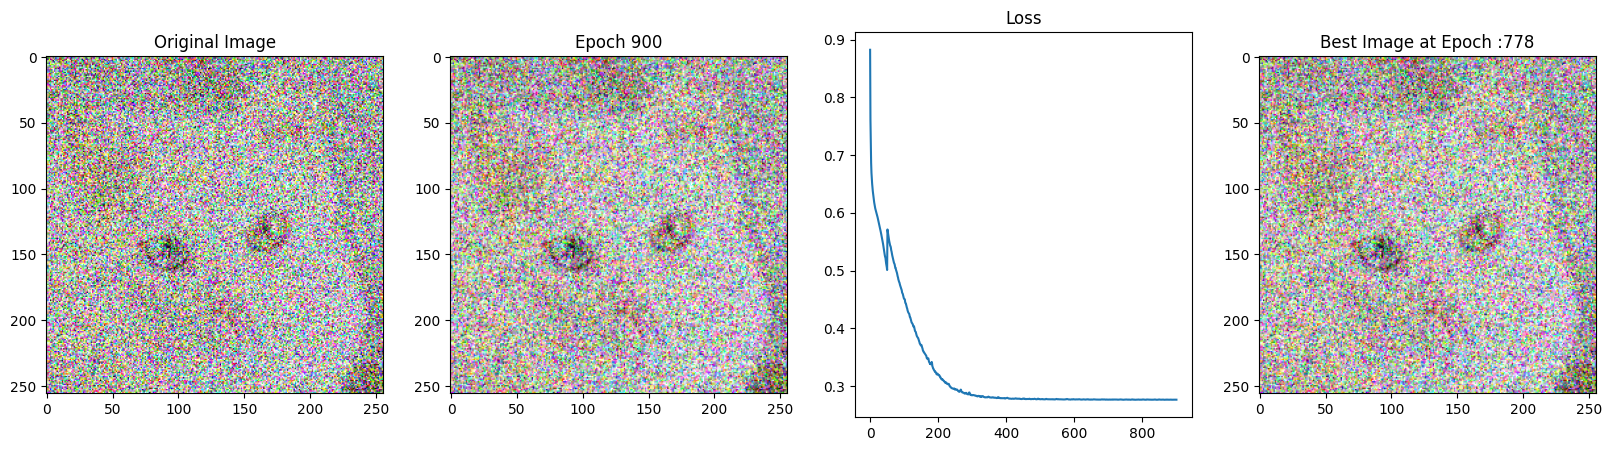

KeyboardInterrupt: 

In [ ]:
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

IMAGE_PATH = "/content/drive/MyDrive/dataset/cat/0013.png"
img = Image.open(IMAGE_PATH).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

img = transform(img)
img = img.unsqueeze(0).to(DEVICE)
print(img.shape)
dataset_img = img

beta_start = 0.0001
beta_end = 0.02
num_timesteps = 1000

betas = torch.linspace(beta_start, beta_end, num_timesteps,device=DEVICE)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

beta =None
sqrt_alphas_cumprod_t = None
sqrt_one_minus_alphas_cumprod_t = None
def get_noisy_img(img,t):
    global beta,sqrt_alphas_cumprod_t,sqrt_one_minus_alphas_cumprod_t
    beta = betas[t]
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t]
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t]
    noise = torch.randn_like(img)
    return sqrt_alphas_cumprod_t * img + sqrt_one_minus_alphas_cumprod_t * noise

class TV_loss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,x):
        horizontal_diff = x[:,:,1:,:] - x[:,:,:-1,:]
        vertical_diff = x[:,:,:,1:] - x[:,:,:,:-1]
        h_sum = torch.sum(torch.abs(horizontal_diff))
        v_sum = torch.sum(torch.abs(vertical_diff))
        return h_sum + v_sum

def plottable_clean_img(img):
    if img.dtype == torch.float32:
        img = img.detach().cpu().squeeze(0).permute(1,2,0).numpy()
        img = img * 0.5 + 0.5
        img = np.clip(img,0,1)
    return img



noisy_img = get_noisy_img(img,torch.tensor(300,device=DEVICE)).to(DEVICE)


def denoising_step(noisy_img):
    model = Unet().to(DEVICE)

    z = torch.randn(noisy_img.shape,device=DEVICE)

    optimizer = torch.optim.AdamW(model.parameters(),lr=0.0001)

    EPOCHS = 2000

    losses = []

    global frames
    frames=[]

    best_loss = float("inf")
    best_img = torch.randn(3,256,256,device=DEVICE)
    best_epoch = 0

    print("Start Training")
    for epoch in range(EPOCHS):
        optimizer.zero_grad()

        reconstructed_img = model(z)
        mse_loss = F.mse_loss(reconstructed_img,noisy_img)

        if epoch > 50:
            tv_loss = TV_loss()(reconstructed_img)
            loss = mse_loss + tv_loss * 1e-6
        else:
            loss = mse_loss

        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        if loss.item() < best_loss:
            best_loss = loss.item()
            best_img = reconstructed_img
            best_epoch = epoch

        if epoch % 1 == 0:
            frames.append(plottable_clean_img(reconstructed_img))

        if epoch % 50 == 0:

          clear_output(wait=True)
          print(f"Epoch {epoch} Loss {loss.item()}")

          fig , (ax_orig , ax_img , ax_loss , ax_best) = plt.subplots(1,4,figsize=(20,5))

          original_img = plottable_clean_img(noisy_img)
          ax_orig.imshow(original_img)
          ax_orig.set_title("Original Image")

          current_img = plottable_clean_img(reconstructed_img)
          ax_img.imshow(current_img)
          ax_img.set_title(f"Epoch {epoch}")

          ax_loss.plot(losses)
          ax_loss.set_title("Loss")

          best_img = plottable_clean_img(best_img)
          ax_best.imshow(best_img)
          ax_best.set_title(f"Best Image at Epoch :{best_epoch}")

          plt.show()

denoising_step(noisy_img)


In [ ]:
import ipywidgets as widgets
from IPython.display import display

print(f"Sqrt(1-alpha_cumprod) : {sqrt_one_minus_alphas_cumprod_t}")
print(f"Sqrt(alpha_cumprod) : {sqrt_alphas_cumprod_t}")
print(len(frames))
def show_frame(frame_idx):
    fig , (ax_frames , ax_orig) = plt.subplots(1,2,figsize=(10,5))
    ax_frames.imshow(frames[frame_idx])
    ax_frames.axis('off')
    ax_frames.set_title(f"Frame {frame_idx} (Approx Iter {frame_idx*1})")

    ax_orig.imshow(plottable_clean_img(noisy_img))
    ax_orig.axis('off')
    ax_orig.set_title("Original Image")
    plt.show()

# Create the slider
slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(frames)-1,
    step=1,
    description='Epoch:',
    continuous_update=True
)

number_box = widgets.BoundedIntText(
    value=0,
    min=0,
    max=len(frames)-1,
    step=1,
    description='Go to Frame:',
    disabled=False
)

widgets.jslink((slider, 'value'), (number_box, 'value'))

# 4. Create the Layout (Box on the left, Slider on the right)
ui = widgets.HBox([number_box, slider])

# 5. Connect to your plotting function
# (We use interactive_output so the plot appears below the controls)
out = widgets.interactive_output(show_frame, {'frame_idx': slider})

# 6. Display
display(ui, out)

#widgets.interactive(show_frame, frame_idx=slider)



Sqrt(1-alpha_cumprod) : 0.7784528732299805
Sqrt(alpha_cumprod) : 0.627703070640564
1074


Output()

(256, 256, 3)


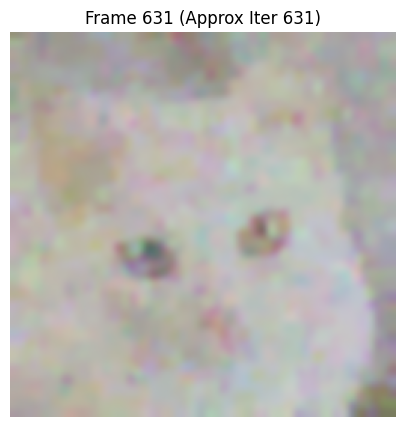

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

frame_idx = 631
frame = frames[frame_idx]
print(frame.shape)

fig ,ax = plt.subplots(1,1,figsize=(10,5))
ax.imshow(frame)
ax.axis('off')
ax.set_title(f"Frame {frame_idx} (Approx Iter {frame_idx*1})")
plt.show()


# Convert Datatype
Numpy float [0,1] -> Numpy uint8 [0,255] -> PIL -> Tensor

In [ ]:
frame = (frame*255).astype(np.uint8)
frame_pil = Image.fromarray(frame)
blurry_img = transform(frame_pil).unsqueeze(0).to(DEVICE)
print(blurry_img.shape)

torch.Size([1, 3, 256, 256])


# If need denoise again

Epoch 1050 Loss 0.004848215263336897


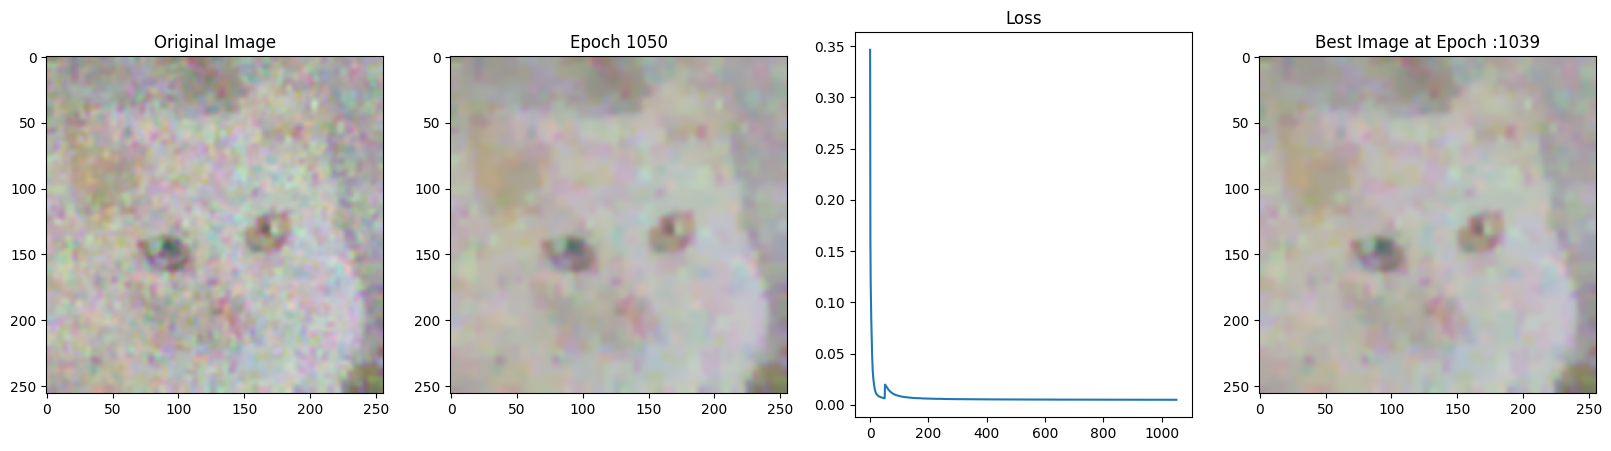

KeyboardInterrupt: 

In [ ]:
denoising_step(blurry_img)

# If Need to Sharpen Image

In [ ]:
import torch
import torch.nn as nn

class ResNetBlock(nn.Module):
    def __init__(self,in_channels,out_channels,dropout_prob = 0.0):
        super(ResNetBlock, self).__init__()
        self.norm1 = nn.GroupNorm(32,in_channels)
        self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1)
        self.norm2 = nn.GroupNorm(32,out_channels)
        self.drop = nn.Dropout(dropout_prob)
        self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1)
        self.silu = nn.SiLU()

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels,out_channels,kernel_size=1)
        else:
            self.shortcut = nn.Identity()

    def forward(self,x):
        x1 = x

        x = self.norm1(x)
        x = self.silu(x)
        x = self.conv1(x)

        x = self.norm2(x)
        x = self.silu(x)
        x = self.drop(x)
        x = self.conv2(x)
        return x + self.shortcut(x1)

class AttentionBlock(nn.Module):
    def __init__(self,in_channels):
        super(AttentionBlock, self).__init__()
        self.norm = nn.GroupNorm(32,in_channels)

        self.to_q = nn.Linear(in_channels,in_channels)
        self.to_k = nn.Linear(in_channels,in_channels)
        self.to_v = nn.Linear(in_channels,in_channels)

        self.to_out = nn.Linear(in_channels,in_channels)

    def forward(self,x):
        residual = x
        B,C,H,W = x.shape
        x = self.norm(x)
        x = x.view(B,C,-1).permute(0,2,1)

        q = self.to_q(x)
        k = self.to_k(x)
        v = self.to_v(x)

        attn = torch.bmm(q,k.permute(0,2,1)) # batch matrix multiplication
        attn = attn * (C**(-0.5))  # sqrt(dk)
        attn = attn.softmax(dim=-1)
        attn = torch.bmm(attn,v)

        out = self.to_out(attn)
        out = out.permute(0,2,1).view(B,C,H,W)

        return out + residual

class MidBlock(nn.Module):
    def __init__(self,in_channels):
        super(MidBlock, self).__init__()
        self.res1 = ResNetBlock(in_channels,in_channels)
        self.attn1 = AttentionBlock(in_channels)
        self.res2 = ResNetBlock(in_channels,in_channels)

    def forward(self,x):
        x = self.res1(x)
        x = self.attn1(x)
        x = self.res2(x)
        return x

class DownBlock(nn.Module):
    def __init__(self,in_channels,out_channels,has_attn=False):
        super(DownBlock, self).__init__()
        self.res1 = ResNetBlock(in_channels,out_channels)
        self.res2 = ResNetBlock(out_channels,out_channels)
        self.down = nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=2,padding=1)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()
    def forward(self,x):
        x = self.res1(x)
        x = self.res2(x)
        x = self.attn(x)
        x = self.down(x)
        return x

class Encoder(nn.Module):
    def __init__(self,in_channels=3,out_channels=4):
        super(Encoder, self).__init__()
        self.inp = nn.Conv2d(in_channels,64,kernel_size=3,padding=1)
        self.down_block = nn.Sequential(
            DownBlock(64,128),
            DownBlock(128,256),
            DownBlock(256,512,has_attn = True)
        )
        self.bottle = MidBlock(512)
        self.out = nn.Sequential(
            nn.GroupNorm(32,512),
            nn.SiLU(),
            nn.Conv2d(512,out_channels*2,kernel_size=1)
        )

    def reparameterize(self,x):
        mean , log_var = torch.chunk(x,2,dim=1)
        log_var = torch.clamp(log_var, -30.0, 20.0)
        D_kl = 0.5 *(torch.exp(log_var) + mean**2 - log_var - 1)
        D_kl = torch.sum(D_kl,dim=[1,2,3]).mean() # Mean is for batch dimention
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        z = mean + eps*std
        return z,D_kl

    def forward(self,x):
        x = self.inp(x)
        x = self.down_block(x)
        x = self.bottle(x)
        x = self.out(x)
        z,D_kl = self.reparameterize(x)
        return z,D_kl

class UpBlock(nn.Module):
    def __init__(self,in_channels,out_channels,has_attn=False):
        super().__init__()
        self.res1 = ResNetBlock(in_channels,out_channels)
        self.res2 = ResNetBlock(out_channels,out_channels)
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2), # nearest mode by default
            nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1)
        )
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()
    def forward(self,x):
        x = self.res1(x)
        x = self.res2(x)
        x = self.attn(x)
        x = self.up(x)
        return x

class Decoder(nn.Module):
    def __init__(self,in_channels=4,out_channels=3):
        super(Decoder, self).__init__()
        self.inp = nn.Conv2d(in_channels,512,kernel_size=3,padding=1)
        self.bottle = MidBlock(512)
        self.up_block = nn.Sequential(
            UpBlock(512,256,has_attn=True),
            UpBlock(256,128),
            UpBlock(128,64)
        )
        self.out = nn.Sequential(
            nn.GroupNorm(32,64),
            nn.SiLU(),
            nn.Conv2d(64,out_channels,kernel_size=3,padding=1)
        )

    def forward(self,x):
        x = self.inp(x)
        x = self.bottle(x)
        x = self.up_block(x)
        x = self.out(x)
        return x

class PatchGan(nn.Module):
    def __init__(self,in_channels=3):
        super(PatchGan, self).__init__()
        self.model=nn.Sequential(
            nn.Conv2d(in_channels,64,kernel_size=3,stride=2,padding=1),
            nn.SiLU(),

            nn.Conv2d(64,128,kernel_size=3,stride=2,padding=1),
            nn.GroupNorm(32,128),
            nn.SiLU(),

            nn.Conv2d(128,256,kernel_size=3,stride=2,padding=1),
            nn.GroupNorm(32,256),
            nn.SiLU(),

            nn.Conv2d(256,512,kernel_size=3,stride=2,padding=1),
            nn.GroupNorm(32,512),
            nn.SiLU(),

            nn.Conv2d(512,1,kernel_size=3,stride=1,padding=1)
        )

    def forward(self,x):
        x = self.model(x)
        return x

class VAE(nn.Module):
    def __init__(self,in_channels=3,out_channels=4):
        super(VAE, self).__init__()
        self.encoder = Encoder(in_channels,out_channels)
        self.decoder = Decoder(out_channels,in_channels)

    def forward(self,x):
        z,D_kl = self.encoder(x)
        x = self.decoder(z)
        return x,D_kl

In [ ]:
def raw_time_embedding(time , dim):
    if not torch.is_tensor(time):
        time = torch.tensor(time)

    device=time.device
    if time.ndim == 0:
        time = time.unsqueeze(0).unsqueeze(1)
    else: # This will be execute in training since t shape is (B)
        time = time.unsqueeze(1)
        # (B) -> (B,1)

    # important to specify device
    i=torch.arange(dim//2,device=device).float()
    obj = (time)/(10000**(2*i/dim))
    return torch.cat([torch.sin(obj),torch.cos(obj)],dim=1)

class time_embedding(nn.Module):
    def __init__(self,dim):
        super().__init__()
        self.net=nn.Sequential(
            nn.Linear(dim,dim),
            nn.SiLU(),
            nn.Linear(dim,dim)
        )

    def forward(self,X):
        return self.net(X)

class DiffusionResNetBlock(nn.Module):
    def __init__(self,in_channels,out_channels,time_emb_dim,dropout_prob = 0.0 ):
        super().__init__()
        self.norm1 = nn.GroupNorm(32,in_channels)
        self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1)
        self.norm2 = nn.GroupNorm(32,out_channels)
        self.drop = nn.Dropout(dropout_prob)
        self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1)
        self.silu = nn.SiLU()

        # purpose of this projection is to match channel dim , before adding to x
        self.time_proj = nn.Linear(time_emb_dim,out_channels)

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels,out_channels,kernel_size=1)
        else:
            self.shortcut = nn.Identity()

    def forward(self,x,time_emb):
        x1 = x

        x = self.norm1(x)
        x = self.silu(x)
        x = self.conv1(x)

        # (B,C) -> (B,C,1,1)
        # why silu ?
        emb = self.time_proj(self.silu(time_emb))
        x = x + emb[:, :, None, None]

        x = self.norm2(x)
        x = self.silu(x)
        x = self.drop(x)
        x = self.conv2(x)
        return x + self.shortcut(x1)

class DiffusionAttentionBlock(nn.Module):
    def __init__(self,in_channels):
        super().__init__()
        self.norm = nn.GroupNorm(32,in_channels)

        self.to_q = nn.Linear(in_channels,in_channels)
        self.to_k = nn.Linear(in_channels,in_channels)
        self.to_v = nn.Linear(in_channels,in_channels)

        self.to_out = nn.Linear(in_channels,in_channels)

    def forward(self,x):
        residual = x
        B,C,H,W = x.shape
        x = self.norm(x)
        x = x.view(B,C,-1).permute(0,2,1)

        q = self.to_q(x)
        k = self.to_k(x)
        v = self.to_v(x)

        attn = torch.bmm(q,k.permute(0,2,1)) # batch matrix multiplication
        attn = attn * (C**(-0.5))  # sqrt(dk)
        attn = attn.softmax(dim=-1)
        attn = torch.bmm(attn,v)

        out = self.to_out(attn)
        out = out.permute(0,2,1).view(B,C,H,W)

        return out + residual

class DiffusionDownBlock(nn.Module):
    def __init__(self,in_channels,out_channels,time_emb_dim,has_attn=False):
        super().__init__()
        self.res1 = DiffusionResNetBlock(in_channels,out_channels,time_emb_dim)
        self.res2 = DiffusionResNetBlock(out_channels,out_channels,time_emb_dim)
        self.down = nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=2,padding=1)
        if has_attn:
            self.attn = DiffusionAttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()
    def forward(self,x,time_emb):
        x = self.res1(x,time_emb)
        x = self.res2(x,time_emb)
        x = self.attn(x)

        skip_connection = x

        x = self.down(x)
        return x , skip_connection

class DiffusionMidBlock(nn.Module):
    def __init__(self,in_channels,time_emb_dim):
        super().__init__()

        self.res1 = DiffusionResNetBlock(in_channels,in_channels,time_emb_dim)
        self.attn = DiffusionAttentionBlock(in_channels)
        self.res2 = DiffusionResNetBlock(in_channels,in_channels,time_emb_dim)

    def forward(self,x,time_emb):
        x = self.res1(x,time_emb)
        x = self.attn(x)
        x = self.res2(x,time_emb)
        return x

class DiffusionUpBlock(nn.Module):
    def __init__(self,in_channels,out_channels,time_emb_dim,has_attn=False):
        super().__init__()

        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels,in_channels,kernel_size=3,padding=1)
        )
        # Why input *2 ? Because we have to concatenate the channels
        self.res1 = DiffusionResNetBlock(in_channels*2,out_channels,time_emb_dim)
        self.res2 = DiffusionResNetBlock(out_channels,out_channels,time_emb_dim)
        if has_attn:
            self.attn = DiffusionAttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()
    def forward(self,x,skip_connection,time_emb):
        x = self.up(x)

        # cancatenate at channels dimension
        x = torch.cat([x,skip_connection],dim=1)
        x = self.res1(x,time_emb)
        x = self.res2(x,time_emb)
        x = self.attn(x)
        return x

class DiffusionUnet(nn.Module):
    def __init__(self,in_channels=4,out_channels=4,time_dim=256):
        super().__init__()

        self.time_dim = time_dim
        self.time_embedding = time_embedding(time_dim)

        self.init_conv = nn.Conv2d(in_channels,64,kernel_size=3,padding=1)

        self.down1 = DiffusionDownBlock(64,64,time_dim)
        self.down2 = DiffusionDownBlock(64,128,time_dim)
        self.down3 = DiffusionDownBlock(128,128,time_dim,has_attn=True)
        self.down4 = DiffusionDownBlock(128,256,time_dim,has_attn=True)

        self.mid = DiffusionMidBlock(256,time_dim)

        self.up1 = DiffusionUpBlock(256,128,time_dim,has_attn=True)
        self.up2 = DiffusionUpBlock(128,128,time_dim,has_attn=True)
        self.up3 = DiffusionUpBlock(128,64,time_dim)
        self.up4 = DiffusionUpBlock(64,64,time_dim)

        self.out = nn.Sequential(
            nn.GroupNorm(32,64),
            nn.SiLU(),
            nn.Conv2d(64,out_channels,kernel_size=3,padding=1)
        )

    def forward(self,x,t):
        t = raw_time_embedding(t,self.time_dim)
        emb = self.time_embedding(t)

        x = self.init_conv(x)

        x1 , skip1 = self.down1(x,emb)
        x2 , skip2 = self.down2(x1,emb)
        x3 , skip3 = self.down3(x2,emb)
        x4 , skip4 = self.down4(x3,emb)

        x = self.mid(x4,emb)

        x = self.up1(x,skip4,emb)
        x = self.up2(x,skip3,emb)
        x = self.up3(x,skip2,emb)
        x = self.up4(x,skip1,emb)

        x = self.out(x)
        return x


Start Processing


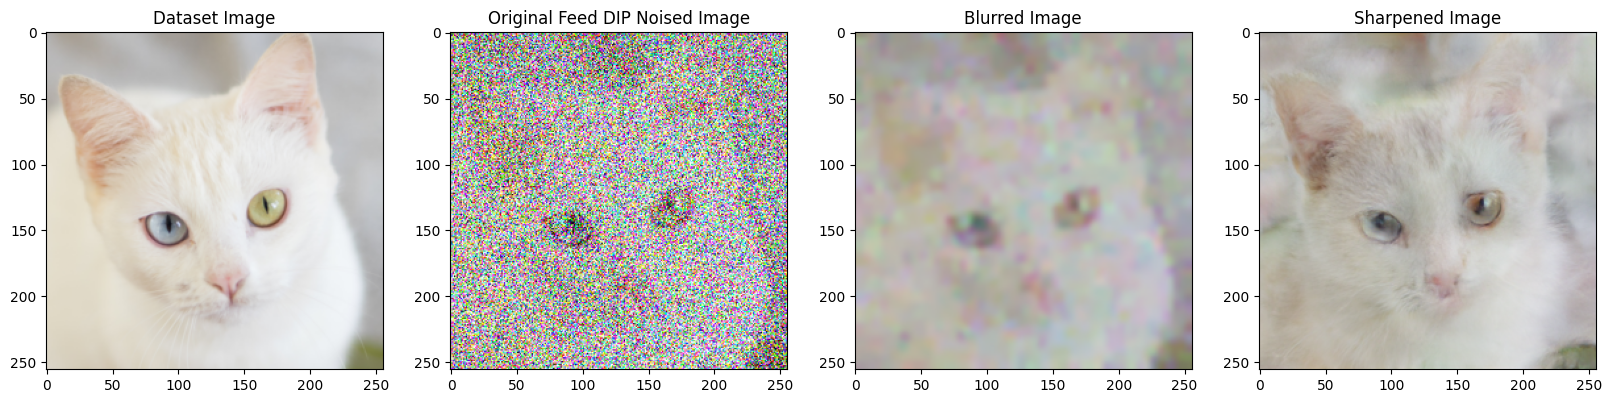

In [ ]:
VAE_CHECKPOINT = "/content/drive/MyDrive/VAE_Training/trained_weight/checkpoint.pth"
UNET_PATH = "/content/drive/MyDrive/VAE_Training/trained_weight/unet_epoch_500.pth"

vae=VAE().to(DEVICE)
checkpoint = torch.load(VAE_CHECKPOINT,map_location=DEVICE)
vae.load_state_dict(checkpoint['vae_state_dict'])
vae.eval()

unet = DiffusionUnet().to(DEVICE)
unet.load_state_dict(torch.load(UNET_PATH))
unet.eval()

timestep=250
print("Start Processing")
with torch.no_grad():
    blurry_latent = vae.encoder(blurry_img)[0]
    noisy_latent = get_noisy_img(blurry_latent,timestep)
    for t in reversed(range(timestep)):
        t_tensor = torch.ones(1,device=DEVICE).long()*t

        alpha = alphas[t]
        alpha_cumprod = alphas_cumprod[t]
        beta = betas[t]
        sqrt_alpha_cumprod = sqrt_alphas_cumprod[t]
        sqrt_one_minus_alpha_cumprod = sqrt_one_minus_alphas_cumprod[t]

        if t>0:
            noise = torch.randn_like(blurry_latent)
        else:
            noise = torch.zeros_like(blurry_latent)

        noise_pred = unet(noisy_latent,t_tensor)

        noisy_latent = (1 / torch.sqrt(alpha)) * (noisy_latent - ((1 - alpha) / (torch.sqrt(1 - alpha_cumprod))) * noise_pred) + torch.sqrt(beta) * noise

    sharp_img = vae.decoder(noisy_latent)
    sharp_img = plottable_clean_img(sharp_img)

fig , (ax_dataset , ax_orig , ax_blur , ax_sharp) = plt.subplots(1,4,figsize=(20,5))

ax_dataset.imshow(plottable_clean_img(dataset_img))
ax_dataset.set_title("Dataset Image")

ax_orig.imshow(plottable_clean_img(noisy_img))
ax_orig.set_title("Original Feed DIP Noised Image")

ax_blur.imshow(plottable_clean_img(blurry_img))
ax_blur.set_title("Blurred Image")

ax_sharp.imshow(sharp_img)
ax_sharp.set_title("Sharpened Image")

plt.show()

